## Neural Machine Translation: German with Attention

#### - Implementing seq2seq NMT using Bahdanau's Attention mechanism. 
#### - Implementing code in tensorflow 2.0 using GRU (gated recurrent unit)

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # trying tensorflow this way, using version 2.0 to check if this helps model 
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import pandas as pd
import unicodedata
import re
import numpy as np
import os
import io
import time
from string import digits

In [2]:
data_path = "deu1.txt"

In [3]:
#Read the data
lines_raw= pd.read_table(data_path,names=['source', 'target'])
lines_raw.sample(5)

,source,target
213100,Tom said that he and Mary would probably be a ...,"Tom sagte, dass er und Maria sich wahrscheinli..."
47240,He called at my house.,Er rief bei mir zu Hause an.
44193,Tom is extremely fit.,Tom sieht richtig geil aus.
2659,Let's start.,Fangen wir an!
179438,The building was heavily damaged by fire.,Das Gebäude wurde durch einen Brand schwer bes...


#### Clean and preprocess the source and target sentences

In [36]:
#Code help from the following sources:
# https://www.researchgate.net/publication/337459762_Neural_Machine_Translation_with_Attention_Based_on_a_New_Syntactic_Branch_Distance
# https://www.aaai.org/ocs/index.php/AAAI/AAAI18/paper/viewFile/16534/15733

In [4]:
def preprocess_sentence(sentence):
    #sentence = unicode_to_ascii(sentence.lower().strip())
    num_digits= str.maketrans('','', digits)
    
    sentence= sentence.lower()
    sentence= re.sub(" +", " ", sentence)
    sentence= re.sub("'", '', sentence)
    sentence= sentence.translate(num_digits)
    sentence= sentence.strip()
    sentence= re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = sentence.rstrip().strip()
    sentence=  'start_ ' + sentence + ' _end'
    
    return sentence

In [6]:
en_sentence = u"May I borrow this book?"
ger_sentence = u"Kann ich mir dieses Buch ausleihen?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(ger_sentence).encode('utf-8'))

start_ may i borrow this book ? _end
b'start_ kann ich mir dieses buch ausleihen ? _end'


In [7]:
en_sentence = u"May I borrow this book?"
ger_sentence = u"Kann ich mir dieses Buch ausleihen?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(ger_sentence).encode('utf-8'))

start_ may i borrow this book ? _end
b'start_ kann ich mir dieses buch ausleihen ? _end'


In [37]:
#code help from https://stackoverflow.com/questions/63268582/bahdanaus-attention-in-neural-machine-translation-with-attention

In [8]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
  
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  #print(lines)
  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
  print(path)
  return zip(*word_pairs)

In [9]:
sample_size=60000
source, target = create_dataset(data_path, sample_size)
print(source[-1])
print(target[-1])
type(target)

deu1.txt
start_ tom tried the shoes on . _end
start_ tom hat die schuhe anprobiert . _end


tuple

### Tokenize source and target sentences

In [38]:
#code help from https://www.mathworks.com/help/deeplearning/ug/sequence-to-sequence-translation-using-attention.html
#code hep from https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwjlmPmzmK_sAhWtc98KHRLJBj8QFjAfegQIHhAC&url=https%3A%2F%2Fcontent.sciendo.com%2Fview%2Fjournals%2Fpralin%2F109%2F1%2Farticle-p39.xml%3Flanguage%3Den&usg=AOvVaw1b6pbDH-bou491Uy0PL_M2

In [10]:
def max_length(tensor):
  return max(len(t) for t in tensor)

In [11]:
source_sentence_tokenizer= tf.keras.preprocessing.text.Tokenizer(filters='')
source_sentence_tokenizer.fit_on_texts(source)
source_tensor = source_sentence_tokenizer.texts_to_sequences(source)
source_tensor= tf.keras.preprocessing.sequence.pad_sequences(source_tensor,padding='post' )

In [12]:
target_sentence_tokenizer= tf.keras.preprocessing.text.Tokenizer(filters='')
target_sentence_tokenizer.fit_on_texts(target)
target_tensor = target_sentence_tokenizer.texts_to_sequences(target)
target_tensor= tf.keras.preprocessing.sequence.pad_sequences(target_tensor,padding='post' )
print(len(target_tensor[0]))

23


In [13]:
max_target_length= max(len(t) for t in  target_tensor)
print(max_target_length)
max_source_length= max(len(t) for t in  source_tensor)
print(max_source_length)

23
11


#### Create training and test dataset

In [39]:
#80/20 split 

In [14]:
source_train_tensor, source_test_tensor, target_train_tensor, target_test_tensor= train_test_split(source_tensor, target_tensor,test_size=0.2)

In [15]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(source_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

48000 48000 12000 12000


In [16]:
type(input_tensor_train)

numpy.ndarray

In [17]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [18]:
print ("Input Language; index to word mapping")
convert(source_sentence_tokenizer, source_train_tensor[0])
print ()
print ("Target Language; index to word mapping")
convert( target_sentence_tokenizer, target_train_tensor[0])

Input Language; index to word mapping
1 ----> start_
89 ----> hes
1987 ----> stalling
45 ----> for
110 ----> time
3 ----> .
2 ----> _end

Target Language; index to word mapping
1 ----> start_
17 ----> er
11299 ----> schindet
140 ----> zeit
980 ----> heraus
3 ----> .
2 ----> _end


In [40]:
# since dataset is big, create dataset in memory to be efficient 
# using tf.data.Dataset.from_tensor_slices() method to get slices of the array in the form of an object.

# dataset will be created in batches of 64

In [41]:
# code help from https://iopscience.iop.org/article/10.1088/1742-6596/1237/5/052020/pdf

In [19]:
BUFFER_SIZE = len(source_train_tensor)
BATCH_SIZE = 64
steps_per_epoch = len(source_train_tensor)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(source_sentence_tokenizer.word_index)+1
vocab_tar_size = len(target_sentence_tokenizer.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((source_train_tensor, target_train_tensor)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
type(dataset)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [20]:
#here we are iterate through all the elements in the dataset. 
# The returned iterator implements the Python iterator protocol and therefore can only be used in eager mode

example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 11]), TensorShape([64, 23]))

### Create the sequence to sequence model with Bahdanau’s Attention using Gated Recurrent Unit(GRU)

#### Create the Encoder

In [42]:
#code help from https://devmesh.intel.com/projects/neural-machine-translation-using-seq2seq

In [49]:
#the encoder takes the input as the source tokens, passes them to an embedding layer for the dense
# -> representation of the vector, which is then passed to the GRU

class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [50]:
#code help from https://lib.dr.iastate.edu/cgi/viewcontent.cgi?article=1228&context=creativecomponents

In [22]:
#test the encoder class and print the dimensions of the encoders output and hidden state 

encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 11, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


### Create the Bahdanau Attention Layer

In [52]:
#code help from https://pubmed.ncbi.nlm.nih.gov/31902775/
#code help from https://talbaumel.github.io/blog/attention/
#code help from https://www.tensorflow.org/addons/api_docs/python/tfa/seq2seq/BahdanauAttention

In [23]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

#### Test the Bahdanau attention layer with ten units

In [24]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 11, 1)


### Create the Decoder

In [55]:
#code help from https://www.coursera.org/lecture/attention-models-in-nlp/training-an-nmt-with-attention-hy9Vc
#code help from https://labs.eleks.com/2019/06/neural-machine-translation-attention-mechanism.html

In [25]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

#### Test the decoder

In [26]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 11931)


### Define the optimzer 

In [56]:
#code help from https://www.aaai.org/ocs/index.php/AAAI/AAAI18/paper/viewFile/16534/15733

In [27]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

### Train the dataset

In [28]:
checkpoint_dir = 'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [57]:
#code help from https://www.mathworks.com/help/deeplearning/ug/sequence-to-sequence-translation-using-attention.html

In [29]:
#Tensorflow keeps track of every gradient for every computation on every tf.Variable
#To train, we use gradient tape to control the areas of code where we need gradient information.
#For seq2seq with the Attention mechanism, we calculate the gradient for the Decoder’s output only.

@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([target_sentence_tokenizer.word_index['start_']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

#### Training the encoder-decoder with attention using multiple epochs

In [58]:
#starting with 2 epochs
#will use more when transfering to cloud computing 

In [35]:
EPOCHS = 1

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss
    if batch % 100 == 0:
      print('Epoch {} Batch {} loss {}'.format(epoch + 1,batch, batch_loss.numpy()))
   
      
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 loss 2.6017744541168213
Epoch 1 Batch 100 loss 1.1616179943084717
Epoch 1 Batch 200 loss 1.0820958614349365
Epoch 1 Batch 300 loss 1.0977997779846191
Epoch 1 Batch 400 loss 0.8588452935218811
Epoch 1 Batch 500 loss 0.8157064914703369
Epoch 1 Batch 600 loss 0.8513568639755249
Epoch 1 Batch 700 loss 0.8250505328178406
Epoch 1 Loss 1.0159
Time taken for 1 epoch 1741.534413099289 sec

Epoch 2 Batch 0 loss 0.6674163341522217
Epoch 2 Batch 100 loss 0.5818440318107605
Epoch 2 Batch 200 loss 0.6414072513580322
Epoch 2 Batch 300 loss 0.5997854471206665
Epoch 2 Batch 400 loss 0.5537751913070679
Epoch 2 Batch 500 loss 0.5057019591331482
Epoch 2 Batch 600 loss 0.5622035264968872
Epoch 2 Batch 700 loss 0.5471608638763428
Epoch 2 Loss 0.5772
Time taken for 1 epoch 1810.5589528083801 sec



### Making Inferences for the test data 

Making inferences is similar to training except that we do not know the actual work that is used in "Teacher
Forcing", so we pass the predicted word from the previous time step to the Decoder.

In [60]:
#code help from https://iopscience.iop.org/article/10.1088/1742-6596/1237/5/052020/pdf
#code help from https://devmesh.intel.com/projects/neural-machine-translation-using-seq2seq

In [43]:
def evaluate(sentence):
  attention_plot = np.zeros((max_target_length, max_source_length))

  sentence = preprocess_sentence(sentence)
  #print(sentence)
  #print(source_sentence_tokenizer.word_index)

  inputs = [source_sentence_tokenizer.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_source_length,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([target_sentence_tokenizer.word_index['start_']], 0)

  for t in range(max_target_length):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += target_sentence_tokenizer.index_word[predicted_id] + ' '

    if target_sentence_tokenizer.index_word[predicted_id] == '_end':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

#### Function to plot the Attention weights between the source words and target words

In [61]:
#code help from https://lib.dr.iastate.edu/cgi/viewcontent.cgi?article=1228&context=creativecomponents

In [44]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

### Translate the source sentence to target sentence

In [62]:
#function to make a call to the evaluate function, which creates the Encoder, Decoder and Attention layer
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)
  
  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [46]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir)) 

## The attention plot for the translated sentence

Input: start_ i am going to work . _end
Predicted translation: ich gehe zur arbeit . _end 


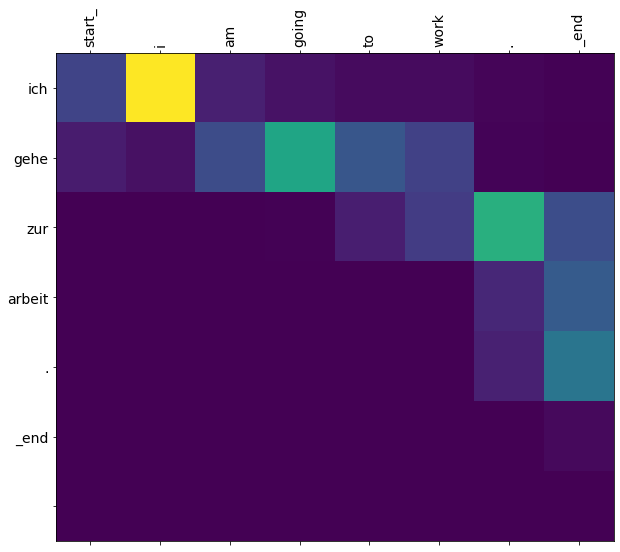

In [47]:
translate(u'I am going to work.')

Input: start_ i will read a book . _end
Predicted translation: ich werde ein buch lesen . _end 


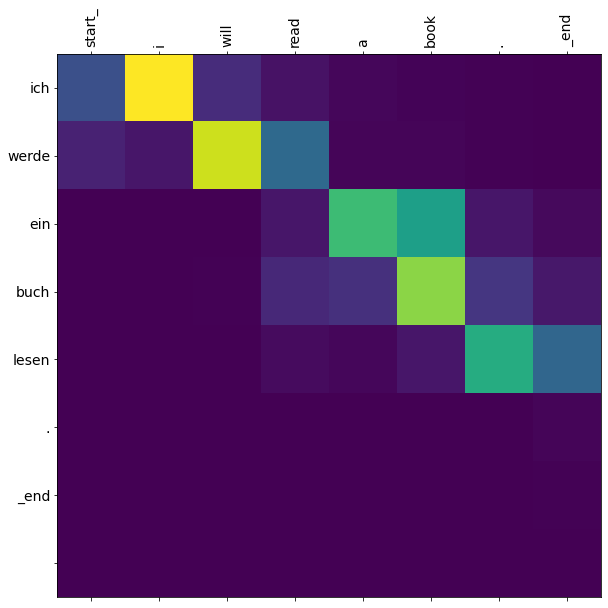

In [48]:
translate(u'I will read a book.')

Input: start_ you will go to the island today . _end
Predicted translation: du wirst es zur schule gehen . _end 


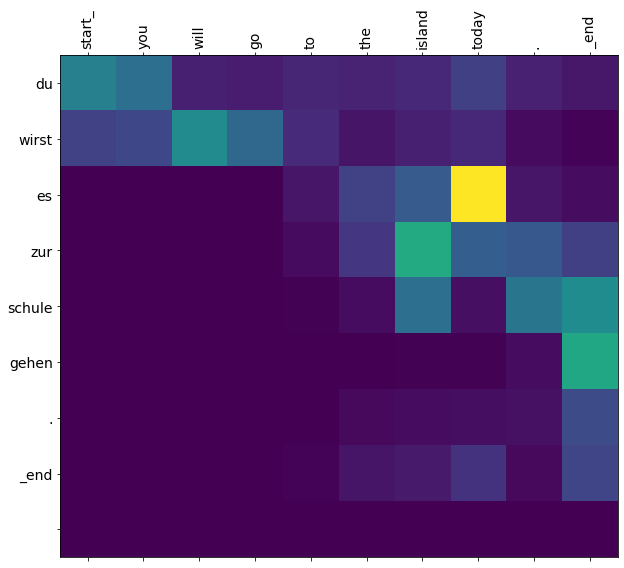

In [41]:
translate(u'You will go to the island today.')